In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/mtmoncur/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
teams_abbr = {'- - -': '- - -', 'ANA': 'Angels', 'ARI': 'Diamondbacks', 
 'ATL': 'Braves', 'BAL': 'Orioles', 'BOS': 'Red Sox', 'CHC': 'Cubs', 
 'CHW': 'White Sox', 'CIN': 'Reds', 'CLE': 'Indians', 'COL': 'Rockies',
 'DET': 'Tigers', 'FLA': 'Marlins', 'HOU': 'Astros', 'KCR': 'Royals', 
 'LAA': 'Angels', 'LAD': 'Dodgers', 'MIA': 'Marlins', 'MIL': 'Brewers',
 'MIN': 'Twins', 'MON': 'Expos', 'NYM': 'Mets', 'NYY': 'Yankees',
 'OAK': 'Athletics', 'PHI': 'Phillies', 'PIT': 'Pirates', 'SDP': 'Padres',
 'SEA': 'Mariners', 'SFG': 'Giants', 'STL': 'Cardinals', 'TBD': 'Devil Rays', 
 'TBR': 'Rays', 'TEX': 'Rangers', 'TOR': 'Blue Jays', 'WSN': 'Nationals'}

In [3]:
#read in all data
sp = pd.read_csv('FanGraphs_Starters (2).csv')
rp = pd.read_csv('FanGraphs_Relievers (2).csv')
fd = pd.read_csv('FanGraphs_Fielders (2).csv')
bt = pd.read_csv('FanGraphs_Batting (2).csv')

a, b, c = len(sp),len(rp),len(fd)
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, a+b+c))

#change abbreviation to full team name
fd.loc[[True]*len(fd),'Team'] = [teams_abbr[k] for k in fd.Team]



Number of starter pitchers:	2741
Number of relief pitchers:	1265
Number of fielders:		16122
-------------------------------------
Total number of records:	20128


In [4]:
bt.columns

Index(['Season', 'Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%',
       'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off',
       'Def', 'WAR', 'playerid'],
      dtype='object')

In [5]:
rp.columns

Index(['Season', 'Name', 'Team', 'W', 'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'FIP', 'xFIP',
       'WAR', 'playerid'],
      dtype='object')

In [6]:
sp.columns

Index(['Season', 'Name', 'Team', 'W', 'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'FIP', 'xFIP',
       'WAR', 'playerid'],
      dtype='object')

In [7]:
print(fd.columns)
fd.sample(5)

Index(['Season', 'Name', 'Team', 'Pos', 'Inn', 'rSB', 'rGDP', 'rARM', 'rGFP',
       'rPM', 'DRS', 'BIZ', 'Plays', 'RZR', 'OOZ', 'CPP', 'RPP', 'TZL', 'FSR',
       'ARM', 'DPR', 'RngR', 'ErrR', 'UZR', 'UZR/150', 'Def', 'playerid'],
      dtype='object')


,Season,Name,Team,Pos,Inn,rSB,rGDP,rARM,rGFP,rPM,...,TZL,FSR,ARM,DPR,RngR,ErrR,UZR,UZR/150,Def,playerid
12567,2004,John Halama,Devil Rays,P,118.2,1.0,NaN,NaN,0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1080
104,2016,Adam Eaton,White Sox,RF,980.1,NaN,NaN,9.0,4,9.0,...,NaN,7.0,9.6,NaN,12.6,0.9,23.1,25.5,18.0,11205
8051,2008,Travis Snider,Blue Jays,LF,99.0,NaN,NaN,1.0,0,-2.0,...,NaN,NaN,-0.2,NaN,-1.0,0.1,-1.0,-20.1,-1.6,2830
1611,2005,Carlos Guillen,Tigers,SS,625.0,NaN,-1.0,NaN,-2,2.0,...,NaN,NaN,NaN,-0.4,-0.4,2.7,1.9,3.8,5.1,1079
6305,2012,Marlon Byrd,Cubs,CF,105.0,NaN,NaN,-1.0,0,2.0,...,NaN,-1.0,-1.8,NaN,1.5,-0.1,-0.5,-1.5,-0.3,950


In [8]:
#create a 3 sets containing tuples of playerids with the season for each record
fd_season_id = set([tuple(row) for row in fd[['playerid','Season']].values])
rp_season_id = set([tuple(row) for row in rp[['playerid','Season']].values])
sp_season_id = set([tuple(row) for row in sp[['playerid','Season']].values])
bt_season_id = set([tuple(row) for row in bt[['playerid','Season']].values])

a, b, c = len(sp_season_id), len(rp_season_id), len(fd_season_id)
total = set()
total.update(sp_season_id);total.update(rp_season_id);total.update(fd_season_id)

print("Only counting players once per season.\n")
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, len(total)))


Only counting players once per season.

Number of starter pitchers:	2675
Number of relief pitchers:	1265
Number of fielders:		12253
-------------------------------------
Total number of records:	12254


In [9]:
print(len(bt_season_id.intersection(fd_season_id)))
print(len(bt_season_id.intersection(rp_season_id)))
print(len(bt_season_id.intersection(sp_season_id)))
print(len(rp_season_id.intersection(fd_season_id)))
print(len(rp_season_id.intersection(sp_season_id)))
print(len(sp_season_id.intersection(fd_season_id)))


8157
0
590
1264
3
2675


In [10]:
#create temporary Seasonid column
fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])
rp.insert(2,'Seasonid',[tuple(row) for row in rp[['playerid','Season']].values])
sp.insert(2,'Seasonid',[tuple(row) for row in sp[['playerid','Season']].values])

#find and remove duplicates between dataframes
#mask = fd.Seasonid.isin(sp_season_id)
#fd.drop(fd[mask].index,inplace=True)

#mask = fd.Seasonid.isin(rp_season_id)
#fd.drop(fd[mask].index,inplace=True)

mask = rp.Seasonid.isin(sp_season_id)
rp.drop(rp[mask].index,inplace=True)

#remove temporary Seasonid column
fd.drop('Seasonid',axis=1,inplace=True)
sp.drop('Seasonid',axis=1,inplace=True)
rp.drop('Seasonid',axis=1,inplace=True)

In [11]:
#change all fielder positions (except catcher) to FD
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'

#add column with potision to prepare for combining data
sp.insert(2, 'Pos', 'SP')
rp.insert(2,'Pos', 'RP')

In [12]:
p = pd.concat([sp,rp,fd], ignore_index=True)
#p = pd.merge(sp,rp, on=['Season', 'Name']'Seasonid', how='outer')
#p = pd.merge(p, fd, on='Seasonid', how='outer')
p.drop(p[p.Season<2002].index,inplace=True)
p.reset_index()

p.sample(5)

,ARM,BABIP,BB/9,BIZ,CPP,DPR,DRS,Def,ERA,ErrR,...,UZR/150,W,WAR,playerid,rARM,rGDP,rGFP,rPM,rSB,xFIP
1696,NaN,0.346,2.24,NaN,NaN,NaN,NaN,NaN,6.13,NaN,...,NaN,3.0,1.2,1574,NaN,NaN,NaN,NaN,NaN,4.1
15528,NaN,NaN,NaN,181.0,NaN,-0.2,6.0,-11.9,NaN,-2.2,...,-2.9,NaN,NaN,13145,NaN,0.0,0.0,6.0,NaN,NaN
5013,-1.1,NaN,NaN,66.0,NaN,NaN,4.0,7.4,NaN,-0.3,...,34.1,NaN,NaN,905,-2.0,NaN,-1.0,7.0,NaN,NaN
17180,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,4897,NaN,NaN,0.0,-2.0,0.0,NaN
4760,NaN,NaN,NaN,201.0,NaN,-0.1,7.0,9.0,NaN,2.0,...,12.6,NaN,NaN,7485,NaN,0.0,-2.0,8.0,NaN,NaN


In [13]:
p = p.drop(['rSB', 'rGDP', 'rARM', 'rGFP',
       'rPM', 'BIZ', 'Plays', 'RZR', 'OOZ', 'CPP', 'TZL', 'FSR',
       'ARM', 'DPR', 'RngR', 'ErrR', 'UZR/150', 'Def',
        'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'xFIP',
       ], axis=1)

In [14]:
p['DRS'].fillna(p['DRS'].mean(), inplace=True)
p['RPP'].fillna(p['RPP'].mean(), inplace=True)
p['UZR'].fillna(p['UZR'].mean(), inplace=True)
p['FIP'].fillna(p['FIP'].mean(), inplace=True)
p['Inn'].fillna(p['Inn'].mean(), inplace=True)
p['WAR'].fillna(p['WAR'].mean(), inplace=True)
p['W'].fillna(p['W'].mean(), inplace=True)


In [15]:
by_pos = p.groupby('Pos')
for g in by_pos.groups:
    group = by_pos.get_group(g)
    print('#'*50)
    print(g)
    for c in p.columns:
        print(c,'\t', len(group)-group[c].count())

##################################################
SP
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0
##################################################
FD
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0
##################################################
C
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0
##################################################
P
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0
##################################################
RP
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0


In [16]:
#account for team name changes
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
del(teams_abbr['MON'])
del(teams_abbr['TBD'])

#delete players from a season if their team is unknown
p.drop(p[p.Team=='- - -'].index,inplace=True)
del(teams_abbr['- - -'])

In [17]:
print("Number of records before:\t{}".format(len(p)))
p.drop_duplicates(inplace=True)
print("Number of records after:\t{}".format(len(p)))

Number of records before:	20125
Number of records after:	20125


In [18]:
p.sample(5)

,DRS,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
11849,1.000000,4.051089,135.1000,Allen Craig,FD,0.018954,2014,Red Sox,-0.200000,7.436672,1.598176,3433
6994,2.000000,4.051089,128.0000,Milton Bradley,FD,0.018954,2004,Dodgers,3.000000,7.436672,1.598176,369
5689,8.000000,4.051089,905.1000,Ian Kinsler,FD,0.018954,2010,Rangers,3.300000,7.436672,1.598176,6195
14448,-11.000000,4.051089,456.2000,Russell Branyan,FD,0.018954,2005,Brewers,-6.000000,7.436672,1.598176,370
527,0.076789,3.900000,364.8328,Jered Weaver,SP,0.018954,2008,Angels,0.053147,11.000000,3.200000,4235


In [19]:
p.dropna(axis=1, how='any')

,DRS,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
0,0.076789,2.300000,364.8328,Randy Johnson,SP,0.018954,2004,Diamondbacks,0.053147,16.000000,9.600000,60
1,0.076789,2.350000,364.8328,Curt Schilling,SP,0.018954,2002,Diamondbacks,0.053147,23.000000,9.400000,73
2,0.076789,2.330000,364.8328,Zack Greinke,SP,0.018954,2009,Royals,0.053147,16.000000,8.600000,1943
3,0.076789,1.990000,364.8328,Clayton Kershaw,SP,0.018954,2015,Dodgers,0.053147,16.000000,8.500000,2036
4,0.076789,2.200000,364.8328,Roy Halladay,SP,0.018954,2011,Phillies,0.053147,19.000000,8.300000,1303
5,0.076789,2.660000,364.8328,Randy Johnson,SP,0.018954,2002,Diamondbacks,0.053147,24.000000,8.100000,60
6,0.076789,2.650000,364.8328,Ben Sheets,SP,0.018954,2004,Brewers,0.053147,12.000000,8.000000,710
7,0.076789,2.470000,364.8328,Mark Prior,SP,0.018954,2003,Cubs,0.053147,18.000000,7.800000,301
8,0.076789,2.800000,364.8328,Justin Verlander,SP,0.018954,2009,Tigers,0.053147,19.000000,7.700000,8700
9,0.076789,2.340000,364.8328,Tim Lincecum,SP,0.018954,2009,Giants,0.053147,15.000000,7.700000,5705


In [20]:
if 'Leave' in p.columns:
    p.drop('Leave', axis=1, inplace=True)
if 'Stay_Length' in p.columns:
    p.drop('Stay_Length', axis=1, inplace=True)

#initialize the new column with value 'No Change'
p.insert(1, 'Leave', 0)
p.insert(1, 'Stay_Length', 0)
by_player = p.groupby('playerid')

#loop through, player by player
for g in by_player.groups:
    one_p = by_player.get_group(g)
    
    counter = 1
    #loop through the years for each player
    for y in sorted(one_p['Season'].unique()):
        p.loc[one_p[one_p.Season==y].index,'Stay_Length'] = counter
        #Case: no next two seasons, counted as leave
        if sum(one_p.Season==y+1)==0:
            if sum(one_p.Season==y+2)==0:
                p.loc[one_p[one_p.Season==y].index,'Leave'] = 1
                counter = 1
            elif (one_p[one_p.Season==y].Team.values[0] != 
                    one_p[one_p.Season==y+2].Team.values[0]):
                p.loc[one_p[one_p.Season==y].index,'Leave'] = 1
                counter = 1
            else:
                counter += 1 
        
        #Case: Leave in next season
        elif (one_p[one_p.Season==y].Team.values[0] != 
                    one_p[one_p.Season==y+1].Team.values[0]):
            p.loc[one_p[one_p.Season==y].index,'Leave'] = 1
            counter = 1
            
        else:
            counter += 1
            


In [21]:
p.sort_values(by=['playerid','Season'])

,DRS,Stay_Length,Leave,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
9789,1.000000,1,0,4.051089,94.1000,Alfredo Amezaga,FD,0.018954,2003,Angels,-0.100000,7.436672,1.598176,1
11242,-2.000000,1,0,4.051089,193.0000,Alfredo Amezaga,FD,0.018954,2003,Angels,-1.900000,7.436672,1.598176,1
6761,0.000000,2,1,4.051089,167.0000,Alfredo Amezaga,FD,0.018954,2004,Angels,1.800000,7.436672,1.598176,1
5093,0.000000,1,0,4.051089,529.0000,Alfredo Amezaga,FD,0.018954,2006,Marlins,6.100000,7.436672,1.598176,1
11906,-1.000000,1,0,4.051089,127.0000,Alfredo Amezaga,FD,0.018954,2006,Marlins,-1.600000,7.436672,1.598176,1
4144,14.000000,2,0,4.051089,643.2000,Alfredo Amezaga,FD,0.018954,2007,Marlins,15.800000,7.436672,1.598176,1
8078,1.000000,2,0,4.051089,122.0000,Alfredo Amezaga,FD,0.018954,2007,Marlins,0.600000,7.436672,1.598176,1
5880,9.000000,3,0,4.051089,457.1000,Alfredo Amezaga,FD,0.018954,2008,Marlins,3.500000,7.436672,1.598176,1
7082,2.000000,3,0,4.051089,125.1000,Alfredo Amezaga,FD,0.018954,2008,Marlins,1.600000,7.436672,1.598176,1
8494,1.000000,3,0,4.051089,73.0000,Alfredo Amezaga,FD,0.018954,2008,Marlins,0.800000,7.436672,1.598176,1


In [22]:
for col in ['P', 'SP', 'RP', 'FD', 'C']:
    if col in p.columns:
        p.drop(col, axis=1, inplace=True)

#one-hot encode positions
for position in p.Pos.unique():
    p.insert(0, position, (p.Pos==position).apply(int))

#one-hot encode teams
for team in p.Team.unique():
    p.insert(0, team, (p.Team==team).apply(int))

p.sample(5)

,Rangers,Orioles,Rays,Pirates,Reds,Athletics,Rockies,Angels,Mariners,Yankees,...,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
11326,0,0,0,1,0,0,0,0,0,0,...,61.1,Sean Rodriguez,FD,0.018954,2016,Pirates,-1.100000,7.436672,1.598176,6589
4954,0,0,0,0,1,0,0,0,0,0,...,906.1,Jason LaRue,C,0.018954,2002,Reds,0.053147,7.436672,1.598176,337
9674,0,0,0,0,0,0,0,0,0,0,...,118.1,Gabe Kapler,FD,0.018954,2008,Brewers,0.700000,7.436672,1.598176,1256
15603,0,0,0,0,0,0,0,0,0,0,...,1080.1,Jacque Jones,FD,0.018954,2005,Twins,-7.500000,7.436672,1.598176,735
12674,0,0,0,0,0,0,0,0,0,0,...,115.0,Julio Lugo,FD,0.018954,2006,Dodgers,-2.300000,7.436672,1.598176,565


In [23]:
temp = p[list(p.Pos.unique())+list(p.Team.unique())+['Stay_Length']]
#temp = p[['Stay_Length', 'FD', 'C', 'P', 'SP', 'RP', 'Inn', 'W', 'WAR', 'DRS', 'RPP', 'UZR', 'FIP']]
#temp['P*WAR'] = temp['P']*temp['WAR']
#temp['P*FIP'] = temp['P']*temp['FIP']
#temp['FD*UZR'] = temp['FD']*temp['UZR']
#temp['C*DRS'] = temp['C']*temp['DRS']

#X = temp[['Stay_Length', 'FD', 'C', 'P', 'RP', 'SP']]#, 'Inn', 'W', 'RPP', 'P*WAR', 'C*DRS', 'FD*UZR', 'P*FIP']]
X = temp

y = p['Leave']

pd.concat([X,y],axis=1)

,SP,RP,FD,C,P,Diamondbacks,Royals,Dodgers,Phillies,Brewers,...,Angels,Rockies,Athletics,Reds,Pirates,Rays,Orioles,Rangers,Stay_Length,Leave
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,5,0
3,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,8,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2,0
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [24]:
results = sm.OLS(y,X).fit()

In [25]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Leave   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.635
Date:                Tue, 23 Jan 2018   Prob (F-statistic):           1.02e-42
Time:                        10:24:31   Log-Likelihood:                -14459.
No. Observations:               20125   AIC:                         2.899e+04
Df Residuals:                   20090   BIC:                         2.926e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
SP               0.3995      0.010     39.411   

In [26]:
np.average(y)

0.49376397515527948

(array([   11.,    77.,   379.,  1735.,  4840.,  6801.,  3944.,  1738.,
          374.,   226.]),
 array([ 0.23804603,  0.28473079,  0.33141555,  0.37810032,  0.42478508,
         0.47146984,  0.51815461,  0.56483937,  0.61152414,  0.6582089 ,
         0.70489366]),
 <a list of 10 Patch objects>)

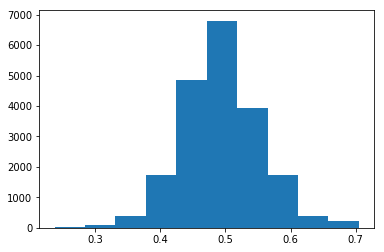

In [27]:
temp = results.predict(X)

plt.hist(temp.values)

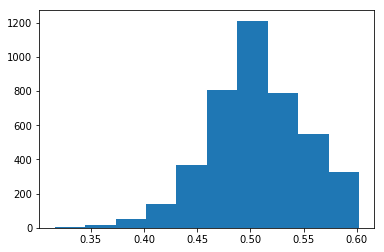

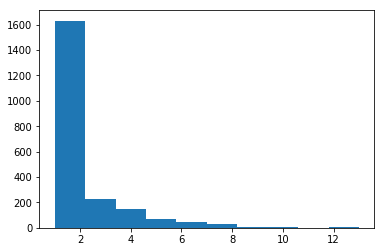

2.0180639184807783

In [28]:
temp = results.predict(X[X.P==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.P==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.P==1)].Stay_Length)

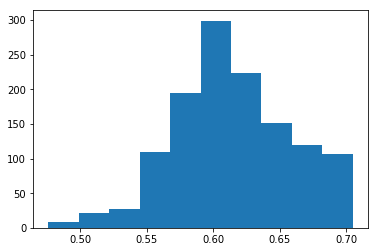

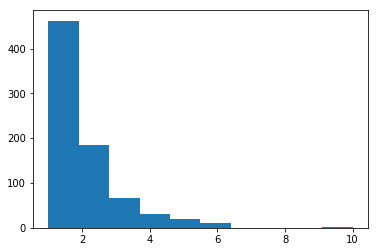

1.7139175257731958

In [29]:
temp = results.predict(X[X.RP==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.RP==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.RP==1)].Stay_Length)

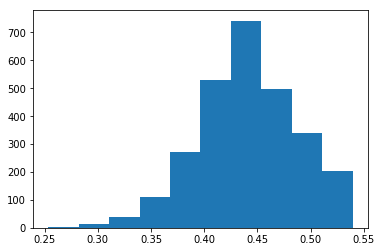

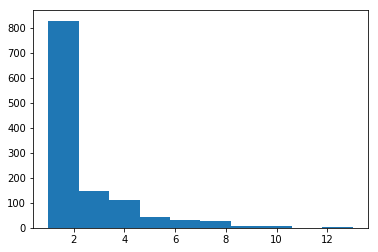

2.2953795379537953

In [30]:
temp = results.predict(X[X.SP==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.SP==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.SP==1)].Stay_Length)

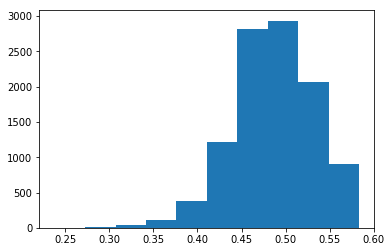

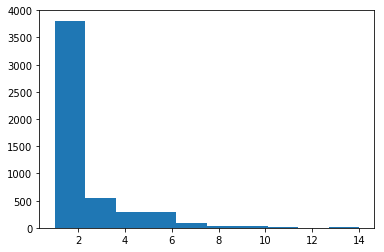

1.0

In [31]:
temp = results.predict(X[X.FD==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.FD==1)].Stay_Length)
plt.show()

np.median(X[(y==1)&(X.FD==1)].Stay_Length)

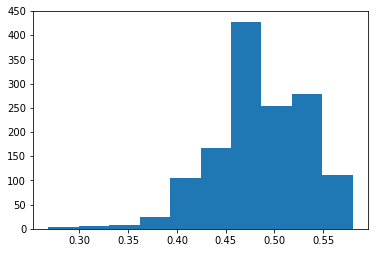

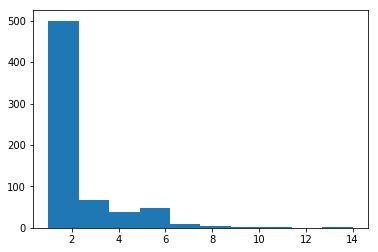

2.1056547619047619

In [32]:
temp = results.predict(X[X.C==1])
plt.hist(temp.values)
plt.show()

plt.hist(X[(y==1)&(X.C==1)].Stay_Length)
plt.show()

np.average(X[(y==1)&(X.C==1)].Stay_Length)

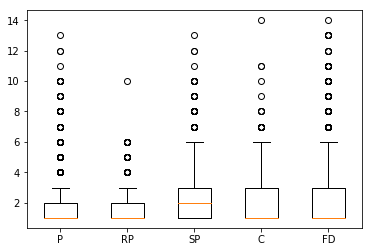

In [33]:
#for col in ['P', 'RP','SP','C','FD']:
#    print(col)
data = [X[(y==1)&(X[col]==1)].Stay_Length.values for col in ['P', 'RP','SP','C','FD']]
plt.boxplot(data)
plt.xticks(np.arange(1,1+5), ['P', 'RP','SP','C','FD'])
plt.show()

In [34]:
X[(y==1)&(X[col]==1)].Stay_Length.values

array([ 1,  3,  2,  2,  4,  2,  2,  2,  1,  3, 14,  3,  2,  6,  1,  4,  1,
        1,  2,  4,  2,  6,  1,  2,  6,  1,  1,  5,  2,  1,  5,  2,  6,  2,
        6,  2,  3,  5,  2,  2,  1,  2,  1,  8,  3,  2,  3,  3,  2,  2,  2,
        1,  1,  3,  8,  7,  6,  1,  3,  1,  1,  1,  2,  9,  7,  1,  2,  1,
        1,  1,  5,  1,  2,  1,  4,  1,  3,  3,  8,  1,  3,  1,  2,  7,  5,
        1,  2,  1,  1,  3,  1,  6,  1,  3,  1,  2, 11,  1,  1,  4,  1,  1,
        4,  1,  6,  3,  2,  1,  1,  1,  7,  4,  3,  1,  1,  4,  1,  3,  1,
        2,  1,  3,  2,  2,  2,  3,  6,  1,  2,  1,  1,  8,  5,  2,  7,  1,
        3,  1,  2,  1,  3,  1,  1,  1,  1,  6,  1,  2,  1,  1,  3,  1,  4,
        5,  2,  1,  1,  2,  4,  1,  2,  1,  3,  4,  1,  1,  1,  1,  1,  2,
        4,  2,  1,  2,  2,  3,  1,  5,  3,  1,  1,  2,  3,  4,  7,  2,  1,
        1,  2,  2,  1,  1,  1,  3,  4,  3,  1,  1,  1,  4,  2,  3,  2,  2,
        1,  1,  1,  2,  1,  1,  1,  1,  2,  2,  1,  2,  3,  3,  5,  5,  1,
        2,  1,  1,  1,  1

## Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

In [ ]:
da

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

rf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [9, 4, 6],
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 2, 3, 5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [5, 1,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(rf, parameters, n_jobs=4)#, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf = grid_obj.best_estimator_


rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
accuracy_score(y_test, rf.predict(X_test))

0.54107320304736672

In [38]:
rf.predict(X_test)

array([1, 0, 0, ..., 1, 1, 0])

## Boosted Forest

In [39]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

et = ExtraTreesClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [9, 4, 6],
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 2, 3, 5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [5, 1,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(et, parameters, n_jobs=4)#, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
et = grid_obj.best_estimator_


et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=10, max_features='log2', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [40]:
accuracy_score(y_test, et.predict(X_test))

0.53892017224246436

In [41]:
et.predict(X_test)

array([1, 0, 1, ..., 0, 0, 1])

## Adaboost

In [42]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

ab = ExtraTreesClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [9, 4, 6],
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [10, 2, 3, 5], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [5, 1,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(ab, parameters, n_jobs=4)#, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
ab = grid_obj.best_estimator_


ab.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=8,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [43]:
accuracy_score(y_test, ab.predict(X_test))

0.54123882080158991

In [44]:
ab.predict(X_test)

array([1, 0, 1, ..., 1, 1, 0])

## Logistic Regression

In [45]:
logreg = LogisticRegressionCV()

logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [46]:
accuracy_score(y_test, logreg.predict(X_test))

0.54504802914872474

## SVM

In [47]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [48]:
accuracy_score(y_test, clf.predict(X_test))

0.54786353097051999